<pre>
1. Download the data from <a href='https://drive.google.com/file/d/15dCNcmKskcFVjs7R0ElQkR61Ex53uJpM/view?usp=sharing'>here</a>

2. Code the model to classify data like below image

<img src='https://i.imgur.com/33ptOFy.png'>

3. Write your own callback function, that has to print the micro F1 score and AUC score after each epoch.

4. Save your model at every epoch if your validation accuracy is improved from previous epoch. 

5. you have to decay learning based on below conditions 
        Cond1. If your validation accuracy at that epoch is less than previous epoch accuracy, you have to decrese the
               learning rate by 10%. 
        Cond2. For every 3rd epoch, decay your learning rate by 5%.
        
6. If you are getting any NaN values(either weigths or loss) while training, you have to terminate your training. 

7. You have to stop the training if your validation accuracy is not increased in last 2 epochs.

8. Use tensorboard for every model and analyse your gradients. (you need to upload the screenshots for each model for evaluation)

9. use cross entropy as loss function

10. Try the architecture params as given below. 
</pre>

<pre>
<b>Model-1</b>
<pre>
1. Use tanh as an activation for every layer except output layer.
2. use SGD with momentum as optimizer.
3. use RandomUniform(0,1) as initilizer.
3. Analyze your output and training process. 
</pre>
</pre>
<pre>
<b>Model-2</b>
<pre>
1. Use relu as an activation for every layer except output layer.
2. use SGD with momentum as optimizer.
3. use RandomUniform(0,1) as initilizer.
3. Analyze your output and training process. 
</pre>
</pre>
<pre>
<b>Model-3</b>
<pre>
1. Use relu as an activation for every layer except output layer.
2. use SGD with momentum as optimizer.
3. use he_uniform() as initilizer.
3. Analyze your output and training process. 
</pre>
</pre>
<pre>
<b>Model-4</b>
<pre>
1. Try with any values to get better accuracy/f1 score.  
</pre>
</pre>

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow_addons as tfa
import seaborn as sns
from sklearn.preprocessing import Normalizer
import matplotlib.pyplot as plt
%load_ext tensorboard
from keras.utils import tf_utils
#https://www.tensorflow.org/guide/keras/custom_callback
#Write F1 Score & AUC score
#Save model if the model accuracy is improving
#At each epoch end, need to change the learning rate

#on_(train|test|predict)_begin(self, logs=None)
#https://medium.com/@thongonary/how-to-compute-f1-score-for-each-epoch-in-keras-a1acd17715a2

In [21]:
%reload_ext tensorboard

In [2]:
data=pd.read_csv('data.csv')

duplicate_data=data
y=duplicate_data['label']

In [3]:
x=duplicate_data.drop('label',axis=1,inplace=False)

In [4]:
norm=Normalizer()
norm.fit(x)
x=norm.transform(x)

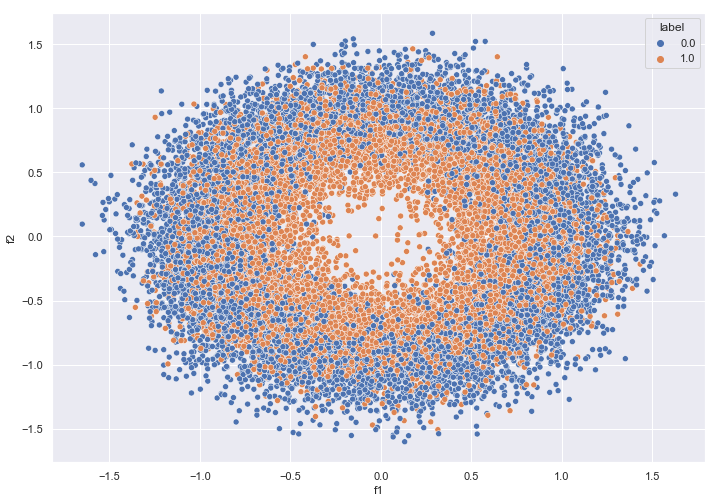

In [5]:
#Plotting to check how our data is, whether separable or complex
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.scatterplot(data=data, x='f1',y='f2',hue='label')
plt.show()

In [28]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2)

<pre>
<b>Model-1</b>
<pre>
1. Use tanh as an activation for every layer except output layer.
2. use SGD with momentum as optimizer.
3. use RandomUniform(0,1) as initilizer.
3. Analyze your output and training process. 

In [26]:
help(tf.keras.callbacks.Callback)

Help on class Callback in module keras.callbacks:

class Callback(builtins.object)
 |  Abstract base class used to build new callbacks.
 |  
 |  Callbacks can be passed to keras methods such as `fit`, `evaluate`, and
 |  `predict` in order to hook into the various stages of the model training and
 |  inference lifecycle.
 |  
 |  To create a custom callback, subclass `keras.callbacks.Callback` and override
 |  the method associated with the stage of interest. See
 |  https://www.tensorflow.org/guide/keras/custom_callback for more information.
 |  
 |  Example:
 |  
 |  >>> training_finished = False
 |  >>> class MyCallback(tf.keras.callbacks.Callback):
 |  ...   def on_train_end(self, logs=None):
 |  ...     global training_finished
 |  ...     training_finished = True
 |  >>> model = tf.keras.Sequential([tf.keras.layers.Dense(1, input_shape=(1,))])
 |  >>> model.compile(loss='mean_squared_error')
 |  >>> model.fit(tf.constant([[1.0]]), tf.constant([[1.0]]),
 |  ...           callbacks

In [7]:
#https://stackoverflow.com/questions/65891168/keras-modelcheckpoint-not-saving-but-earlystopping-is-working-fine-with-the-same

class CustomCallback(tf.keras.callbacks.Callback):
    
    def __init__(self,x_val,y_val):
        super().__init__()
        self.x_val = x_val
        self.y_val = y_val
        pass
    
    def on_train_begin(self, logs={}):
        ## on begin of training, we are creating a instance varible called history
        ## it is a dict with keys [loss, acc, val_loss, val_acc]
        self.history={'loss': [],'accuracy': [],'val_loss': [],'val_accuracy': [],'f1':[],'auc':[]}
        pass
    
        
    def on_epoch_end(self, epoch, logs={}):
        ## on end of each epoch, we will get logs and update the self.history dict
        self.history['loss'].append(logs.get('loss'))
        self.history['accuracy'].append(logs.get('accuracy'))
        if logs.get('val_loss', -1) != -1:
            self.history['val_loss'].append(logs.get('val_loss'))
        if logs.get('val_accuracy', -1) != -1:
            self.history['val_accuracy'].append(logs.get('val_accuracy'))
            
        y_pred=tf.reshape((self.model.predict(self.x_val)),(1,-1)).numpy()[0]
        y_pred[y_pred==-1]=0
        y_pred=y_pred.astype('int32')
        y_true=self.y_val.astype('int32')
        
        #getting the f1 score
        f1=tfa.metrics.F1Score(num_classes=2, threshold=0.5,average='micro')       
        f1.update_state(y_true, y_pred)
        f1_score = f1.result().numpy()
        print('F1 Score is ',f1_score)
        self.history['f1'].append(f1_score)
        
        #getting the AUC Score
        a=tf.keras.metrics.AUC(num_thresholds=len(self.y_val))
        a.update_state(y_true,y_pred)
        auc=a.result().numpy()
        print('AUC Score is ',auc)
        self.history['auc'].append(auc)
        
        file_path="model_save/weights_"+ model_1.name +'epoch'+str(epoch)+'.hdf5' 
        
        #Updating the learning rate
        lr=float(tf.keras.backend.get_value(self.model.optimizer.learning_rate))
        
        if epoch>=2:
            
            if self.history['val_accuracy'][-1]>self.history['val_accuracy'][-2]:
                self.model.save(file_path)
            
            if self.history['val_accuracy'][-1]<self.history['val_accuracy'][-2]:
                print('Validation_Accuracy is more than the previous epoch, hence decreasing by 10%')
                lr=lr*0.9
                
            if epoch%3==0:
                print('Decreasing the learning rate by 5% after every 3rd epoch')
                lr=lr*0.95
        tf.keras.backend.set_value(self.model.optimizer.learning_rate,lr)
        #Found this syntax in https://stackoverflow.com/questions/69758568/how-to-change-learning-rate-in-tensorflow-after-a-batch-end
        #print(self.model.optimizer.learning_rate)
        
        #https://stackoverflow.com/questions/64806541/performing-np-isnan-on-keras-model-weighta-fails-with-typeerror-ufunc-isnan-n
        #Code to check if any of the weights is Nan
        if (logs.get("loss")==None) or np.any([np.any(np.isnan(x)) for x in self.model.get_weights()]):
            print('weights/loss is NAN hence stopping the training')
            self.model.stop_training=True
            
        #Checking if the val_Acc has increased and then stopping training if not improving
        if epoch>=3:
            if all([self.history['val_accuracy'][-1]<=self.history['val_accuracy'][-2],self.history['val_accuracy'][-1]<=self.history['val_accuracy'][-3],self.history['val_accuracy'][-2]<=self.history['val_accuracy'][-3]]):
                print('val_accuracy not improving since the last 2 epochs, hence stopping training')
                self.model.stop_training=True
            
        pass
    


In [27]:
#Clearing Logs before running the Model
import shutil
shutil.rmtree('logs')

In [34]:
model_1=tf.keras.models.Sequential([tf.keras.layers.InputLayer(input_shape=(2,)),
                                    
                                   tf.keras.layers.Dense(2,activation='tanh',kernel_initializer=tf.keras.initializers.RandomUniform(minval=0, maxval=1,seed=30)),
                                    tf.keras.layers.BatchNormalization(),

                                   tf.keras.layers.Dense(300,activation='tanh',kernel_initializer=tf.keras.initializers.RandomUniform(minval=0, maxval=1,seed=20)),
                                    tf.keras.layers.BatchNormalization(),
                                    
                                   tf.keras.layers.Dense(200,activation='tanh',kernel_initializer=tf.keras.initializers.RandomUniform(minval=0, maxval=1,seed=10)),
                                   tf.keras.layers.BatchNormalization(),
                                    
                                   tf.keras.layers.Dense(100,activation='tanh',kernel_initializer=tf.keras.initializers.RandomUniform(minval=0, maxval=1,seed=13)),
                                   tf.keras.layers.BatchNormalization(),
                                    
                                   tf.keras.layers.Dense(1,activation='sigmoid',kernel_initializer=tf.keras.initializers.RandomUniform(minval=0, maxval=1,seed=15)),
                                   ])


tensor=tf.keras.callbacks.TensorBoard(log_dir='logs/model_1',histogram_freq=1)

loss=tf.keras.losses.BinaryCrossentropy()
#Compile is compulsory before fitting
model_1.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.2,momentum=0.01),loss=loss,metrics=['accuracy'])
model_1.fit(x_train,y_train,epochs=30,batch_size=30,validation_data=(x_test,y_test), callbacks=[CustomCallback(x_test,y_test),tensor])

Epoch 1/30
534/534 [==============================] - 4s 6ms/step - loss: 0.9727 - accuracy: 0.5006 - val_loss: 1.0249 - val_accuracy: 0.5010
F1 Score is  0.0
AUC Score is  0.5
Epoch 2/30
534/534 [==============================] - 2s 4ms/step - loss: 0.7129 - accuracy: 0.4946 - val_loss: 0.7204 - val_accuracy: 0.4950
F1 Score is  0.0
AUC Score is  0.5
Epoch 3/30
534/534 [==============================] - 2s 4ms/step - loss: 0.7039 - accuracy: 0.4999 - val_loss: 0.7571 - val_accuracy: 0.4983
F1 Score is  0.0
AUC Score is  0.5
Epoch 4/30
534/534 [==============================] - 2s 4ms/step - loss: 0.7011 - accuracy: 0.5014 - val_loss: 0.6939 - val_accuracy: 0.4967
F1 Score is  0.0
AUC Score is  0.5
Validation_Accuracy is more than the previous epoch, hence decreasing by 10%
Decreasing the learning rate by 5% after every 3rd epoch
Epoch 5/30
534/534 [==============================] - 2s 4ms/step - loss: 0.6990 - accuracy: 0.4997 - val_loss: 0.6964 - val_accuracy: 0.5038
F1 Score is  0.0

In [35]:
%tensorboard --logdir {'./logs'}  --host localhost

Reusing TensorBoard on port 6006 (pid 10804), started 0:10:45 ago. (Use '!kill 10804' to kill it.)

<b>Model-2</b>
<pre>
1. Use relu as an activation for every layer except output layer.
2. use SGD with momentum as optimizer.
3. use RandomUniform(0,1) as initilizer.
3. Analyze your output and training process.

In [29]:
x_train.shape

(16000, 2)

In [30]:
model_1=tf.keras.models.Sequential([tf.keras.layers.InputLayer(input_shape=(2,)),
                                    
                                   tf.keras.layers.Dense(2,activation='relu',kernel_initializer=tf.keras.initializers.RandomUniform(minval=0, maxval=1,seed=30)),
                                    tf.keras.layers.BatchNormalization(),

                                   tf.keras.layers.Dense(400,activation='relu',kernel_initializer=tf.keras.initializers.RandomUniform(minval=0, maxval=1,seed=20)),
                                    tf.keras.layers.BatchNormalization(),
                                    
                                   tf.keras.layers.Dense(250,activation='relu',kernel_initializer=tf.keras.initializers.RandomUniform(minval=0, maxval=1,seed=10)),
                                   tf.keras.layers.BatchNormalization(),
                                    
                                   tf.keras.layers.Dense(100,activation='relu',kernel_initializer=tf.keras.initializers.RandomUniform(minval=0, maxval=1,seed=1)),
                                   tf.keras.layers.BatchNormalization(),
                                    
                                   tf.keras.layers.Dense(1,activation='sigmoid',kernel_initializer=tf.keras.initializers.RandomUniform(minval=0, maxval=1,seed=2)),
                                   
                                   ])

loss=tf.keras.losses.BinaryCrossentropy()

tensor=tf.keras.callbacks.TensorBoard(log_dir='logs/model_2',histogram_freq=1)

#Compile is compulsory before fitting
model_1.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.2,momentum=0.01),loss=loss,metrics=['accuracy'])

model_1.fit(x_train,y_train,epochs=30,batch_size=30,validation_data=(x_test,y_test), callbacks=[CustomCallback(x_test,y_test),tensor])

Epoch 1/30
534/534 [==============================] - 5s 6ms/step - loss: 0.8097 - accuracy: 0.5046 - val_loss: 0.7018 - val_accuracy: 0.4952
F1 Score is  0.0
AUC Score is  0.5
Epoch 2/30
534/534 [==============================] - 2s 4ms/step - loss: 0.6976 - accuracy: 0.4972 - val_loss: 0.6960 - val_accuracy: 0.4952
F1 Score is  0.0
AUC Score is  0.5
Epoch 3/30
534/534 [==============================] - 2s 4ms/step - loss: 0.6972 - accuracy: 0.4963 - val_loss: 0.6948 - val_accuracy: 0.4952
F1 Score is  0.0
AUC Score is  0.5
Epoch 4/30
534/534 [==============================] - 2s 4ms/step - loss: 0.6962 - accuracy: 0.4972 - val_loss: 0.7002 - val_accuracy: 0.5048
F1 Score is  0.0
AUC Score is  0.5
Decreasing the learning rate by 5% after every 3rd epoch
Epoch 5/30
534/534 [==============================] - 2s 4ms/step - loss: 0.6956 - accuracy: 0.4968 - val_loss: 0.6947 - val_accuracy: 0.4952
F1 Score is  0.0
AUC Score is  0.5
Validation_Accuracy is more than the previous epoch, hence

<b>Model-3</b>
<pre>
1. Use relu as an activation for every layer except output layer.
2. use SGD with momentum as optimizer.
3. use he_uniform() as initilizer.
3. Analyze your output and training process.

In [31]:
model_1=tf.keras.models.Sequential([tf.keras.layers.InputLayer(input_shape=(2,)),
                                    
                                   tf.keras.layers.Dense(50,activation='relu',kernel_initializer=tf.keras.initializers.HeUniform(seed=30)),
                                   tf.keras.layers.BatchNormalization(),
                                    
                                   tf.keras.layers.Dense(30,activation='relu',kernel_initializer=tf.keras.initializers.HeUniform(seed=1)),
                                   tf.keras.layers.BatchNormalization(),
                                    
                                   tf.keras.layers.Dense(30,activation='relu',kernel_initializer=tf.keras.initializers.HeUniform(seed=20)),
                                   tf.keras.layers.BatchNormalization(),
                                   
                                   tf.keras.layers.Dense(10,activation='relu',kernel_initializer=tf.keras.initializers.HeUniform(seed=10)),
                                   tf.keras.layers.BatchNormalization(),
                                   
                                   tf.keras.layers.Dense(1,activation='sigmoid',kernel_initializer=tf.keras.initializers.HeUniform(seed=2)),
                                   ])

loss=tf.keras.losses.BinaryCrossentropy()

tensor=tf.keras.callbacks.TensorBoard(log_dir='logs/model_3',histogram_freq=1)

#Compile is compulsory before fitting
model_1.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.2,momentum=0.01),loss=loss,metrics=['accuracy'])

model_1.fit(x_train,y_train,epochs=30,batch_size=30,validation_data=(x_test,y_test), callbacks=[CustomCallback(x_test,y_test),tensor])

Epoch 1/30


C:\Anaconda3\lib\site-packages\keras\backend.py:4994: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`binary_crossentropy` received `from_logits=True`, but the `output`'
C:\Anaconda3\lib\site-packages\keras\backend.py:4994: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`binary_crossentropy` received `from_logits=True`, but the `output`'


534/534 [==============================] - ETA: 0s - loss: 0.7009 - accuracy: 0.5015

C:\Anaconda3\lib\site-packages\keras\backend.py:4994: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`binary_crossentropy` received `from_logits=True`, but the `output`'


534/534 [==============================] - 4s 4ms/step - loss: 0.7009 - accuracy: 0.5015 - val_loss: 0.6941 - val_accuracy: 0.5055
F1 Score is  0.0
AUC Score is  0.5
Epoch 2/30
534/534 [==============================] - 2s 3ms/step - loss: 0.6973 - accuracy: 0.4948 - val_loss: 0.7083 - val_accuracy: 0.4900
F1 Score is  0.0
AUC Score is  0.5
Epoch 3/30
534/534 [==============================] - 1s 3ms/step - loss: 0.6963 - accuracy: 0.4988 - val_loss: 0.6937 - val_accuracy: 0.4970
F1 Score is  0.0
AUC Score is  0.5
Epoch 4/30
534/534 [==============================] - 1s 3ms/step - loss: 0.6961 - accuracy: 0.4889 - val_loss: 0.6974 - val_accuracy: 0.4895
F1 Score is  0.0
AUC Score is  0.5
Validation_Accuracy is more than the previous epoch, hence decreasing by 10%
Decreasing the learning rate by 5% after every 3rd epoch
Epoch 5/30
534/534 [==============================] - 1s 3ms/step - loss: 0.6950 - accuracy: 0.5019 - val_loss: 0.6954 - val_accuracy: 0.5010
F1 Score is  0.0
AUC Score 

<b>Model-4</b>
<pre>
1. Try with any values to get better accuracy/f1 score.  
</pre>
</pre>

In [32]:
model_1=tf.keras.models.Sequential([tf.keras.layers.InputLayer(input_shape=(2,)),
                                    
                                   tf.keras.layers.Dense(2,activation='sigmoid',kernel_initializer=tf.keras.initializers.RandomNormal(seed=5)),
                                    
                                   tf.keras.layers.Dense(400,activation='sigmoid',kernel_initializer=tf.keras.initializers.RandomNormal(seed=20)),
                                    tf.keras.layers.BatchNormalization(),
                                    
                                   tf.keras.layers.Dense(150,activation='sigmoid',kernel_initializer=tf.keras.initializers.RandomNormal(seed=100)),
                                   tf.keras.layers.BatchNormalization(),
                                    
                                   tf.keras.layers.Dense(50,activation='sigmoid',kernel_initializer=tf.keras.initializers.RandomNormal(seed=80)),
                                   tf.keras.layers.BatchNormalization(),
                                    
                                    tf.keras.layers.Dense(50,activation='sigmoid',kernel_initializer=tf.keras.initializers.RandomNormal(seed=80)),
                                   tf.keras.layers.BatchNormalization(),
                                    
                                    tf.keras.layers.Dense(50,activation='sigmoid',kernel_initializer=tf.keras.initializers.RandomNormal(seed=80)),
                                   tf.keras.layers.BatchNormalization(),
                                    
                                    tf.keras.layers.Dense(50,activation='sigmoid',kernel_initializer=tf.keras.initializers.RandomNormal(seed=80)),
                                   tf.keras.layers.BatchNormalization(),
                                    
                                    tf.keras.layers.Dense(50,activation='sigmoid',kernel_initializer=tf.keras.initializers.RandomNormal(seed=80)),
                                   tf.keras.layers.BatchNormalization(),
                                    
                                   tf.keras.layers.Dense(1,activation='sigmoid',kernel_initializer=tf.keras.initializers.RandomNormal(seed=2)),
                                   
                                   ])


loss=tf.keras.losses.BinaryCrossentropy()

tensor=tf.keras.callbacks.TensorBoard(log_dir='logs/model_4',histogram_freq=1)

#Compile is compulsory before fitting
model_1.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.1),loss=loss,metrics=['accuracy'])

model_1.fit(x_train,y_train,epochs=30,batch_size=20,validation_data=(x_test,y_test), callbacks=[CustomCallback(x_test,y_test),tensor])

Epoch 1/30
800/800 [==============================] - 6s 5ms/step - loss: 0.7069 - accuracy: 0.4948 - val_loss: 0.6959 - val_accuracy: 0.5048
F1 Score is  0.0
AUC Score is  0.5
Epoch 2/30
800/800 [==============================] - 3s 4ms/step - loss: 0.7032 - accuracy: 0.4967 - val_loss: 0.6936 - val_accuracy: 0.4952
F1 Score is  0.0
AUC Score is  0.5
Epoch 3/30
800/800 [==============================] - 3s 4ms/step - loss: 0.7013 - accuracy: 0.5012 - val_loss: 0.7134 - val_accuracy: 0.5048
F1 Score is  0.0
AUC Score is  0.5
Epoch 4/30
800/800 [==============================] - 3s 4ms/step - loss: 0.7072 - accuracy: 0.4986 - val_loss: 0.7049 - val_accuracy: 0.4952
F1 Score is  0.0
AUC Score is  0.5
Validation_Accuracy is more than the previous epoch, hence decreasing by 10%
Decreasing the learning rate by 5% after every 3rd epoch
Epoch 5/30
800/800 [==============================] - 3s 4ms/step - loss: 0.7008 - accuracy: 0.5002 - val_loss: 0.6958 - val_accuracy: 0.5048
F1 Score is  0.0